In [1]:
import gymnasium as gym
import numpy as np
import mediapy as media
import torch
# torch.multiprocessing.set_start_method('spawn')
# from act.policy import ACTPolicy
import gym_lite6.env, gym_lite6.scripted_policy
%env MUJOCO_GL=egl # Had to export this before starting jupyter server
import mujoco

pygame 2.2.0 (SDL 2.30.2, Python 3.10.9)
Hello from the pygame community. https://www.pygame.org/contribute.html
env: MUJOCO_GL=egl # Had to export this before starting jupyter server


In [2]:
scene_path = "../models/cube_pickup.xml"
model = mujoco.MjModel.from_xml_path(scene_path)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)


ValueError: mjParseXML: resource not found via provider or OS filesystem: '../models/cube_pickup.xml'

""

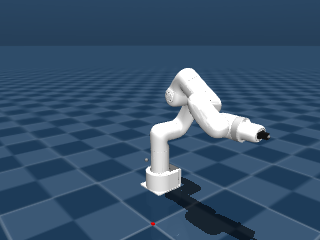

In [5]:

camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 1.2
camera.elevation = -15
camera.azimuth = -130
camera.lookat = (0, 0, 0.3)

mujoco.mj_forward(model, data)

renderer.update_scene(data, camera)
media.show_image(renderer.render())


In [6]:
DURATION = 4          # seconds
FRAMERATE = 60        # Hz
frames = []
x0 = np.array([1.546, 0.541, 1.49 , 2.961, 0.596, 0.203])
mujoco.mj_resetData(model, data)
qpos = x0
data.qpos[:6] = qpos

while data.time < DURATION:
  # Move the target
  # pos, quat = pose(data.time, speed=1)

  data.ctrl[:6] = qpos
  # print(data.qpos)

  # data.qpos = 0.001
  if data.time < DURATION / 2:
    data.ctrl[6] = 30
  else:
    data.ctrl[6] = -30

  # mujoco.mj_camlight(model, data)
  mujoco.mj_step(model, data)
  # print(data.qfrc_actuator, data.qfrc_applied)

  if len(frames) < data.time * FRAMERATE:
    renderer.update_scene(data, camera)
    frames.append(renderer.render())
  
  qpos[0] -= 0.001

media.show_video(frames, loop=False)

In [2]:
class PickupTask(object):
    def __init__(self, l_gripper_name, r_gripper_name, box_name, floor_name) -> None:
        """
        geom ids
        """
        self.l_gripper_name = l_gripper_name
        self.r_gripper_name = r_gripper_name
        self.box_name = box_name
        self.floor_name = floor_name
        self.max_reward = 5
    
    def get_reward(self, model, data):
        """
        1 - close to box and not touching ground
        2 - one gripper touching box and not touching ground
        3 - two grippers touching box and not touching ground
        4 - two grippers touching box and box not touching ground
        5 - two grippers touching box and box > 0.2 in z
        """

        l_gripper_touching_ground = False
        r_gripper_touching_ground = False
        box_touching_ground = False
        l_gripper_touching_box = False
        r_gripper_touching_box = False

        for geom in data.contact.geom:
            if all(np.isin(geom, [model.geom(self.floor_name).id, model.geom(self.l_gripper_name).id])):
              l_gripper_touching_ground = True
            
            if all(np.isin(geom, [model.geom(self.floor_name).id, model.geom(self.r_gripper_name).id])):
              r_gripper_touching_ground = True
                        
            if all(np.isin(geom, [model.geom(self.floor_name).id, model.geom(self.box_name).id])):
              box_touching_ground = True
            

            if all(np.isin(geom, [model.geom(self.box_name).id, model.geom(self.l_gripper_name).id])):
              l_gripper_touching_box = True
            if all(np.isin(geom, [model.geom(self.box_name).id,  model.geom(self.r_gripper_name).id])):
              r_gripper_touching_box = True
        
        gripper_touching_ground = l_gripper_touching_ground or r_gripper_touching_ground
        close_to_box = np.linalg.norm(data.body(self.l_gripper_name).xpos - data.body(self.box_name).xpos) < 0.07
        box_above_height = data.body(self.box_name).xpos[2] > 0.2

        # print(f"gripper_touching_ground: {gripper_touching_ground}, box_touching_ground: {box_touching_ground}, l_gripper_touching_box: {l_gripper_touching_box}, r_gripper_touching_box: {r_gripper_touching_box}, close_to_box: {close_to_box}, box_above_height: {box_above_height}")

        reward = 0
        if l_gripper_touching_box and r_gripper_touching_box and box_above_height:
            assert(not box_touching_ground)
            assert(not gripper_touching_ground)
            assert(close_to_box)
            reward = 5
        elif l_gripper_touching_box and r_gripper_touching_box and not box_touching_ground and not gripper_touching_ground:
            assert(close_to_box)
            reward = 4
        elif l_gripper_touching_box and r_gripper_touching_box and not gripper_touching_ground:
            assert(close_to_box)
            reward = 3
        elif l_gripper_touching_box or r_gripper_touching_box and not gripper_touching_ground:
            assert(close_to_box)
            reward = 2
        elif close_to_box and not gripper_touching_ground:
            reward = 1
        
        return reward
  
task = PickupTask('gripper_left_finger', 'gripper_right_finger', 'box', 'floor')

camera.distance = 0.5
camera.elevation = -10
# camera.azimuth = -130
camera.lookat = (0.1, 0.1, 0)

voption = mujoco.MjvOption()
voption.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = False
voption.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True

f = []
mujoco.mj_resetData(model, data)
mujoco.mj_forward(model, data)
renderer.update_scene(data, camera, voption); f.append(renderer.render())
reward = task.get_reward(model, data)
assert reward == 0, f"Reward is {reward}, contacts: {data.contact}"

# Gripper touching ground near cube
data.qpos = np.array([0.57, 1.04, 1.2, -0.00014, 0.00034, 5.1e-05, -0.0086, 0.0083, 0.3, 0.22, 0.005, 0.65, -0.65, 0.28, -0.28])
mujoco.mj_forward(model, data)
renderer.update_scene(data, camera, voption); f.append(renderer.render())
reward = task.get_reward(model, data)
assert reward == 0, f"Reward is {reward}, contacts: {data.contact}"

# Close to box
data.qpos = np.array([0.75, 0.73, 0.96, -0.00021, 0.00023, -1.4e-06, -0.0095, 0.0086, 0.2, 0.2, 0.01, 1, -1.7e-06, 1.8e-06, -0.0023])
mujoco.mj_forward(model, data)
renderer.update_scene(data, camera, voption); f.append(renderer.render())
reward = task.get_reward(model, data)
assert reward == 1, f"Reward is {reward}, contacts: {data.contact}"

# One gripper touching box
data.qpos = np.array([0.75, 0.86, 0.97, -0.00027, 0.0029, -0.00015, -0.0096, 0.0087, 0.2, 0.2, 0.01, 1, -3.5e-05, -6.1e-05, -0.0039])
mujoco.mj_forward(model, data)
renderer.update_scene(data, camera, voption); f.append(renderer.render())
reward = task.get_reward(model, data)
assert reward == 2, f"Reward is {reward}, contacts: {data.contact}"

# Two grippers touching box but also touching ground
data.qpos = np.array([0.82, 0.981, 1.1, -0.00012, -1.6e-05, 1.6e-05, -0.0066, 0.0085, 0.2, 0.21, 0.005, 0.71, -0.71, 0.052, -0.052])
mujoco.mj_forward(model, data)
renderer.update_scene(data, camera, voption); f.append(renderer.render())
reward = task.get_reward(model, data)
assert reward == 0, f"Reward is {reward}, contacts: {data.contact.geom}"

## Seems to be an issue with feeding qpos in and getting contact with both grippers

# Two grippers touching box and box on ground
data.qpos = np.array([0.63, 1.19, 1.6, -0.0004, 0.39, -5.6e-07, -0.0049, 0.0051, 0.3, 0.21, 0.005, 0.63, -0.63, 0.32, -0.32])
# data.ctrl = np.array([0.63, 1.2, 1.7, 0, 0.39, 0, 1.5])
mujoco.mj_forward(model, data)
renderer.update_scene(data, camera, voption); f.append(renderer.render())
reward = task.get_reward(model, data)
media.show_images(f)
assert reward == 3, f"Reward is {reward}, contacts: {data.contact.geom}"

# data.qpos = np.array([0.82, 1, 1.2, -0.00022, 0.00026, -4.4e-06, -0.0043, 0.0062, 0.22, 0.23, 0.013, 0.69, -0.65, 0.21, -0.23])
# mujoco.mj_forward(model, data)
# renderer.update_scene(data, camera, voption); f.append(renderer.render())
# reward = task.get_reward(model, data)
# assert reward == 4, f"Reward is {reward}, contacts: {data.contact}"

# # Lifted
# data.qpos = np.array([0.82, 0.42, 1.2, -0.00068, 0.00086, -1.4e-06, -0.004, 0.006, 0.27, 0.29, 0.23, 0.82, -0.44, 0.17, -0.32])
# mujoco.mj_forward(model, data)
# camera.lookat = (0.1, 0.1, 0.2)
# renderer.update_scene(data, camera, voption); f.append(renderer.render())
# reward = task.get_reward(model, data)
# assert reward == 4, f"Reward is {reward}, contacts: {data.contact}"




NameError: name 'camera' is not defined

""

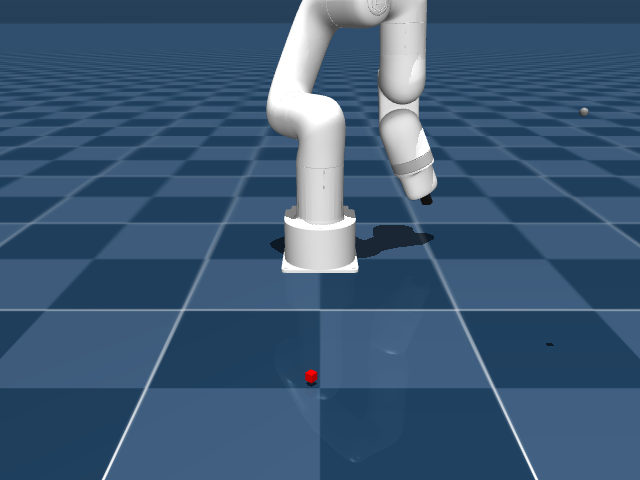

In [3]:
from importlib import reload

reload(gym_lite6.env)
reload(gym_lite6.utils)
reload(gym_lite6.scripted_policy)
env = gym.make(
    "UfactoryCubePickup-v0",
    task=task,
    obs_type="pixels_state",
    max_episode_steps=300,
)
observation, info = env.reset()
media.show_image(env.unwrapped.render(camera="side_cam"))


## Run a scripted rollout

In [5]:
# Run a scripted rollout

policy = gym_lite6.scripted_policy.ScriptedPickupPolicy(env, 'end_effector', 'box', 'gripper_left_finger', 'gripper_right_finger', max_vel=0.2)

# Reset the policy and environmens to prepare for rollout
policy.reset()
observation, info = env.reset(seed=69)

frames = []
# Render frame of the initial state
frames.append(env.render())

step = 0
done = False

ep_dict = {"action.qpos": [], "action.gripper": [], "observation.state.qpos": [], "observation.state.qvel": [], "observation.state.gripper": [], "observation.pixels.side": [], "observation.pixels.gripper": [], "reward": [], "timestamp": [], "frame_index": [],}

while not done and len(frames) < 500:
  action = policy(env.unwrapped.model, env.unwrapped.data, observation, info)
  observation, reward, terminated, truncated, info = env.step(action)

  ep_dict["action.qpos"].append(action["qpos"])
  ep_dict["action.gripper"].append(action["gripper"])
  ep_dict["observation.state.qpos"].append(observation["state"]["qpos"])
  ep_dict["observation.state.qvel"].append(observation["state"]["qvel"])
  ep_dict["observation.state.gripper"].append(observation["state"]["gripper"])
  ep_dict["observation.pixels.side"].append(observation["pixels"]["side"])
  ep_dict["observation.pixels.gripper"].append(observation["pixels"]["gripper"])
  ep_dict["reward"].append(reward)
  ep_dict["timestamp"].append(env.unwrapped.data.time)
  ep_dict["frame_index"].append(step)

  if (policy.stage == 4):
      truncated = True
  print(f"{step=} {reward=} {terminated=}")

  # The rollout is considered done when the success state is reach (i.e. terminated is True),
  # or the maximum number of iterations is reached (i.e. truncated is True)
  done = terminated | truncated | done
  step += 1

if terminated:
  print("Success!")
else:
  print(f"Failure! Reached {policy.stage}")

media.show_video(ep_dict["observation.pixels.side"], fps=env.metadata["render_fps"])
media.show_video(ep_dict["observation.pixels.gripper"], fps=env.metadata["render_fps"])


{0: {'start_time': 0.0, 'end_time': 3.4220019139120184, 'T_start': array([[-0.44640074, -0.89481968, -0.00491047,  0.24616276],
       [ 0.71271997, -0.35222741, -0.60660208, -0.27718353],
       [ 0.54106988, -0.27428741,  0.79499044,  0.66600635],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'T_end': array([[ 1.        ,  0.        ,  0.        ,  0.32186106],
       [ 0.        , -1.        ,  0.        , -0.36832675],
       [ 0.        ,  0.        , -1.        ,  0.0235    ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'goal_pos': array([ 0.32186106, -0.36832675,  0.0235    ]), 'goal_quat': array([0, 1, 0, 0])}}
step=0 reward=0 terminated=False
step=1 reward=0 terminated=False
step=2 reward=0 terminated=False
step=3 reward=0 terminated=False
step=4 reward=0 terminated=False
step=5 reward=0 terminated=False
step=6 reward=0 terminated=False
step=7 reward=0 terminated=False
step=8 reward=0 terminated=False
step=9 reward=0 terminated=False
step=10

dict_keys(['action.qpos', 'action.gripper', 'observation.state.qpos', 'observation.state.qvel', 'observation.state.gripper', 'observation.pixels.side', 'observation.pixels.gripper', 'reward', 'timestamp', 'frame_index'])


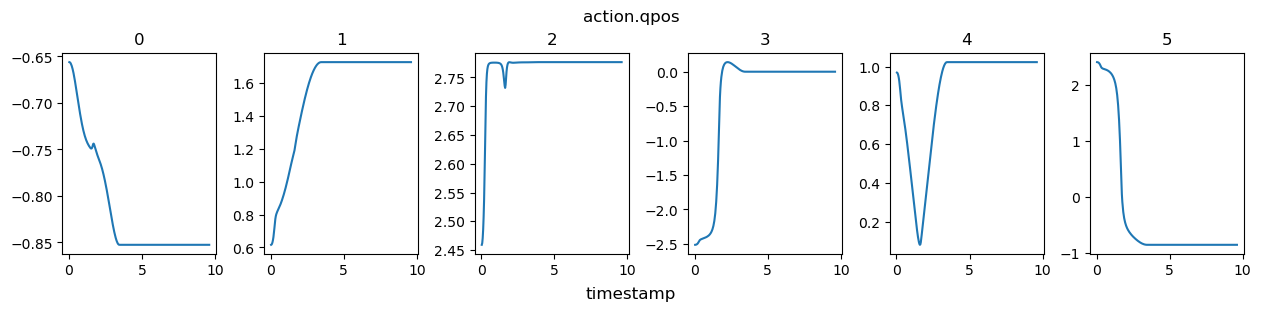

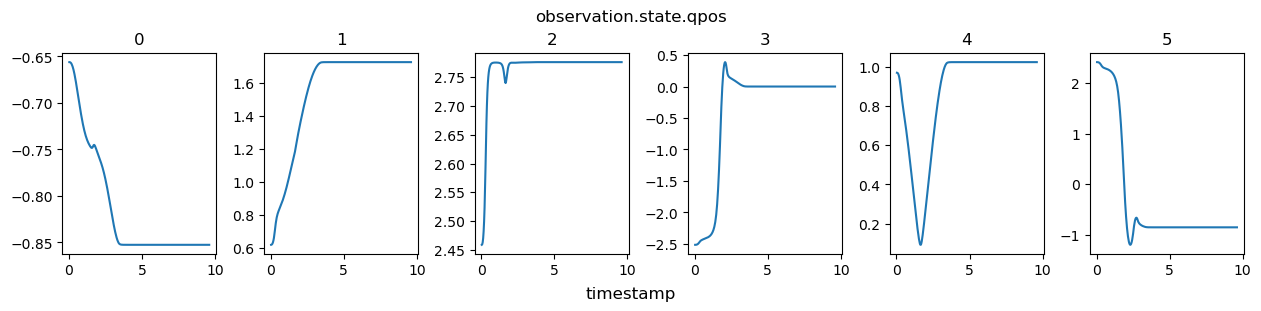

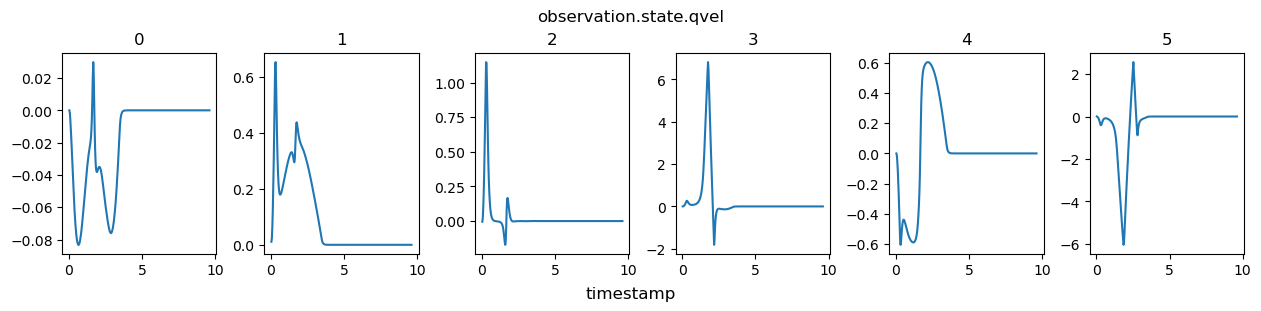

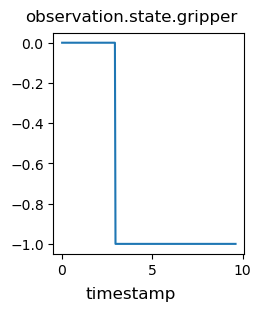

In [6]:
print(ep_dict.keys())

gym_lite6.utils.plot_dict_of_arrays(ep_dict, "timestamp", keys=["action.qpos", "observation.state.qpos", "observation.state.qvel", "observation.state.gripper"], sharey=False)


## Record to h5py
Don't use this - may as well go straight to a hugging face dataset
This is how the original Aloha stored the data.

In [110]:
import h5py
import os

def create_h5py_dataset(data_dict, group):
  for key, val in data_dict.items():
    if isinstance(val, dict):
      grp = group.create_group(key)
      create_h5py_dataset(data_dict[key], grp)
    elif isinstance(val, list):
      group.create_dataset(key, data=val)

def record_episodes(env, policy, dataset_dir, n=1, len=300):

  if not os.path.isdir(dataset_dir):
    os.makedirs(dataset_dir, exist_ok=True)

  successful_trajectories = 0

  while successful_trajectories < n:
    episode_idx = successful_trajectories
    print(f"Episode {episode_idx}")
    observation, info = env.reset()
    policy.reset()

    data = {"action": {"qpos": [], "gripper": []}, "observation": {"state": {"qpos": [], "gripper": []}, "pixels": []}, "reward": []}
    for step in range(len):
      action = policy(env.unwrapped.model, env.unwrapped.data, observation, info)
      observation, reward, terminated, truncated, info = env.step(action)

      # action = {"qpos": step, "gripper": 0}
      # observation = {"qpos": step, "gripper": 1}
      # reward = 2
      # print(observation)
      # print(data)
      data["action"]["qpos"].append(action["qpos"])
      data["action"]["gripper"].append(action["gripper"])
      data["observation"]["state"]["qpos"].append(observation["state"]["qpos"])
      data["observation"]["state"]["gripper"].append(observation["state"]["gripper"])
      data["observation"]["pixels"].append(observation["pixels"])
      data["reward"].append(reward)
    
    if policy.stage == 4:
      path = dataset_dir + f"/ep_{episode_idx}"
      with h5py.File(path + ".hdf5", "w") as f:
        create_h5py_dataset(data, f)
      # out = cv2.VideoWriter(path + ".mp4", cv2.VideoWriter_fourcc(*'mp4v'), env.metadata["render_fps"], (w, h))
      media.write_video(path + ".mp4", data["observation"]["pixels"], fps=env.metadata["render_fps"])
      successful_trajectories += 1
      print(f"Success, saved {path}")
    else:
      print("Failed, retrying")

    media.show_video(data["observation"]["pixels"])

    

## Record to HF dataset

In [6]:
import lerobot.common.datasets.push_dataset_to_hub.utils
from datasets import Dataset, Features, Image, Sequence, Value
from lerobot.common.datasets.push_dataset_to_hub.utils import concatenate_episodes
from lerobot.common.datasets.utils import (
    hf_transform_to_torch,
)
import os
import datetime

def record_episodes_to_hf(env, policy, dataset_dir, num_ep=1, num_frames=350):
  features = {}
  num_readings = num_ep*num_frames
  features["observation.pixels.side"] = Image()
  features["observation.pixels.gripper"] = Image()
  features["observation.state.qpos"] = Sequence(length=6, feature=Value(dtype="float32", id=None))
  features["observation.state.qvel"] = Sequence(length=6, feature=Value(dtype="float32", id=None))
  features["observation.state.gripper"] = Value(dtype="int8", id=None)
  features["reward"] = Value(dtype="int8", id=None)
  features["action.qpos"] = Sequence(length=6, feature=Value(dtype="float32", id=None))
  features["action.gripper"] = Value(dtype="int8", id=None)
  features["episode_index"] = Value(dtype="int64", id=None) # Which episode
  features["frame_index"] = Value(dtype="int64", id=None) # Which frame within episode
  features["timestamp"] = Value(dtype="float32", id=None)
  # features["next.done"] = Value(dtype="bool", id=None)
  features["index"] = Value(dtype="int64", id=None) # Which frame in the whole datasets

  if not os.path.isdir(dataset_dir):
    os.makedirs(dataset_dir, exist_ok=True)

  successful_trajectories = 0
  data_dict = {"action.qpos": [], "action.gripper": [], "observation.state.qpos": [], "observation.state.qvel": [], "observation.state.gripper": [], "observation.pixels.side": [], "observation.pixels.gripper": [], "reward": [], "timestamp": [], "episode_index": [], "frame_index": [], "index": [],}

  while successful_trajectories < num_ep:
    ep_idx = successful_trajectories
    print(f"Episode {ep_idx}")
    observation, info = env.reset()
    policy.reset()

    ep_dict = {"action.qpos": [], "action.gripper": [], "observation.state.qpos": [], "observation.state.qvel": [], "observation.state.gripper": [], "observation.pixels.side": [], "observation.pixels.gripper": [], "reward": [], "timestamp": [], "frame_index": [],}
    ep_dict["episode_index"] = [ep_idx] * num_frames

    for step in range(num_frames):
      action = policy(env.unwrapped.model, env.unwrapped.data, observation, info)
      observation, reward, terminated, truncated, info = env.step(action)

      ep_dict["action.qpos"].append(action["qpos"])
      ep_dict["action.gripper"].append(action["gripper"])
      ep_dict["observation.state.qpos"].append(observation["state"]["qpos"])
      ep_dict["observation.state.qvel"].append(observation["state"]["qvel"])
      ep_dict["observation.state.gripper"].append(observation["state"]["gripper"])
      ep_dict["observation.pixels.side"].append(observation["pixels"]["side"])
      ep_dict["observation.pixels.gripper"].append(observation["pixels"]["gripper"])
      ep_dict["reward"].append(reward)
      ep_dict["timestamp"].append(env.unwrapped.data.time)
      ep_dict["frame_index"].append(step)
      # data_dict["index"] = step
    
    if policy.stage == 4:
      
      # for key in ep_dict:
      #   # Setting the dtype/transforming to a tensor makes no difference as HF Datasets stores everything in Arrow format anyway
      #   dtype = getattr(torch, features[key].feature.dtype) if 'feature' in features[key].__dict__ and features[key].feature.dtype in torch.__dict__ else None
      #   ep_dict[key] = torch.tensor(ep_dict[key], dtype=dtype)
            
      media.show_video(ep_dict["observation.pixels.side"])
      for key in ep_dict:
        data_dict[key].extend(ep_dict[key])

      base_idx = successful_trajectories*num_frames
      data_dict["index"].extend(range(base_idx, base_idx + num_frames))

      successful_trajectories += 1
    else:
      print("Failed, retrying")

  print("Creating dataset")
  # data_dict = concatenate_episodes(ep_dicts)
  # print(data_dict, features)
  hf_dataset = Dataset.from_dict(data_dict, features=Features(features))
  
  hf_dataset.save_to_disk(dataset_dir + f"/scripted_trajectories_{num_ep}_{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.hf")

  return hf_dataset


In [ ]:
policy = gym_lite6.scripted_policy.ScriptedPickupPolicy(env, 'end_effector', 'box', 'gripper_left_finger', 'gripper_right_finger', max_vel=0.2)
# record_episodes(env, policy, "dataset/pickup_side_cam", n=50)
hf_dataset = record_episodes_to_hf(env, policy, "datasets/pickup", num_ep=50)
hf_dataset.set_transform(hf_transform_to_torch)
